In [7]:
import sys, os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from keras import backend as K

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [8]:
trainDataDir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/Training'
testDataDir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PublicTest'

In [75]:
dataLabels = {
    "Angry": 0,
    "Disgust": 1,
    "Fear": 2,
    "Happy": 3,
    "Sad": 4,
    "Surprise": 5,
    "Neutral": 6
}

def loadDataset(datasetDirectory):
    global dataLabels
    data = []
    labels = []
    
    emotionDirList = os.listdir(datasetDirectory)
    for folder in emotionDirList:
        # Folder exists but has not been selected so we ignore it
        if folder not in dataLabels.keys():
            continue
        
        label = dataLabels[folder]
        
        # Iterate over the images
        imageList = os.listdir(datasetDirectory + "/" + folder)
        for imgName in imageList:
            img = cv2.imread(datasetDirectory + '/'+ folder + '/'+ imgName)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            data.append(np.array(img.ravel(),'float32'))
            labels.append(label)
    
    return data, labels


X_train, train_y = loadDataset(trainDataDir)
X_test, test_y = loadDataset(testDataDir)

X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')
X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

print(train_y.shape, test_y.shape, X_train.shape, X_test.shape)
not_categorial_test_y = test_y.copy()

(28709,) (3589,) (28709, 2304) (3589, 2304)


In [76]:
num_features = 64
num_labels = 7
batch_size = 32
epochs = 30
width, height = 48, 48

train_y = np_utils.to_categorical(train_y, num_classes=num_labels)
test_y = np_utils.to_categorical(test_y, num_classes=num_labels)

# Data is normalized between 0 and 1
# Train
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)
# Test
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)
# Reshape
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


In [10]:
num_features = 64
num_labels = 7
batch_size = 32
epochs = 30
width, height = 48, 48

train_y = np_utils.to_categorical(train_y, num_classes=num_labels)
test_y = np_utils.to_categorical(test_y, num_classes=num_labels)

# Data is normalized between 0 and 1
# Train
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)
# Test
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)
# Reshape
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


# 1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

# 2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

# 3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

# Fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

# Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

# Training the model
history = model.fit(X_train, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, test_y),
          shuffle=True)


# Saving the  model to  use it later on
fer_json = model.to_json()
with open("FER.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("FER_MODEL.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 64)          0

In [77]:

model2 = load_model(r'C:\Users\New User\Desktop\Fourth Year\Usability_Testing_FYP\Src\Emotion_little_vgg2.h5')
predictions = model.predict(x=X_test, verbose=0)

In [78]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    fig = plt.figure(num=None, figsize=(20, 50), dpi=80, facecolor='w', edgecolor='k')
    fig.add_subplot(9, 2, 1)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(3589,)
Confusion matrix, without normalization


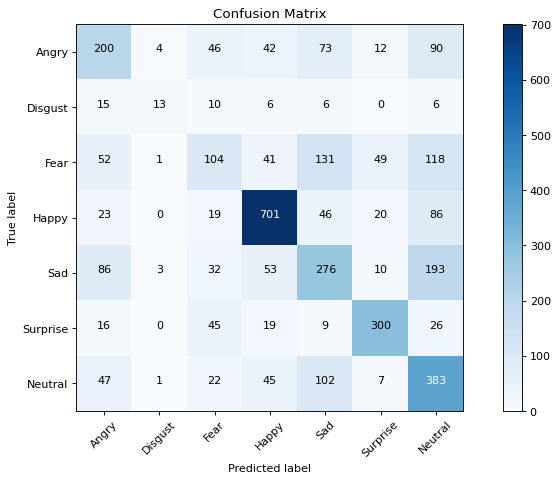

In [79]:
emotionsList = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

print(not_categorial_test_y.shape)

cm = confusion_matrix(y_true=not_categorial_test_y, y_pred=np.argmax(predictions, axis=-1))
plot_confusion_matrix(cm=cm, classes=emotionsList, title='Confusion Matrix')

In [ ]:
fig = plt.figure(num=None, figsize=(20, 50), dpi=80, facecolor='w', edgecolor='k')
fig.add_subplot(9, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
fig = plt.figure(num=None, figsize=(20, 50), dpi=80, facecolor='w', edgecolor='k')
fig.add_subplot(9, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()